In [1]:
pip install pandas scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded 622389 total rows from 76 files.
       sendtime       rcvtime  senderID  messageID  \
0  25200.003363  25200.003479       262        860   
1  25200.006415  25200.006520       160        934   
2  25200.009710  25200.009819       130       1356   
3  25200.011873  25200.011986       154       1441   
4  25200.012893  25200.013008        94       1625   

                                       position  \
0    [5732.167012765934, 4891.38384378471, 0.0]   
1   [5817.589821564664, 5087.721446209872, 0.0]   
2   [5745.959105265088, 4893.973772397958, 0.0]   
3   [5904.747163215797, 5219.536367086424, 0.0]   
4  [5735.823659478266, 4912.1616541037265, 0.0]   

                                            speed  heading  ddostype  msgtype  
0                                 [0.0, 0.0, 0.0]   2.0395         0        0  
1   [6.309877460424007, -3.0760420570534235, 0.0]   2.0395         0        0  
2                                [-0.0, 0.0, 0.0]   2.0395         0        0  
3  [-3.3

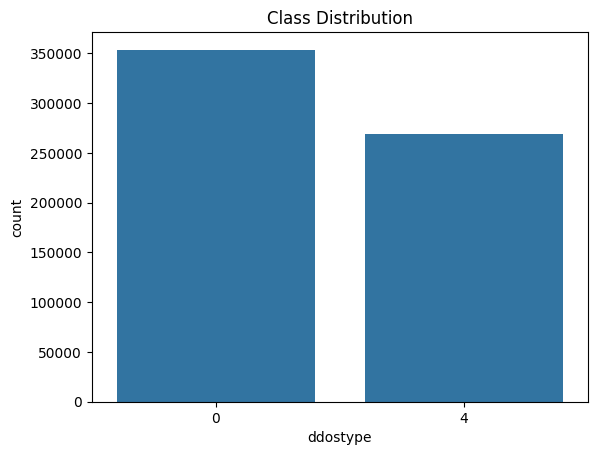

ValueError: setting an array element with a sequence.

In [2]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# === Step 1: List of files to merge ===
# Assuming all files are named like 'Dataset_timewin_1.json', 'Dataset_timewin_2.json', etc.

file_list = glob.glob("Dataset_pkt_*.json")


# === Step 2: Load and Merge ===
dataframes = []

for file in file_list:
    with open(file, 'r') as f:
        data = [json.loads(line) for line in f]
        df_temp = pd.DataFrame(data)
        dataframes.append(df_temp)

# Concatenate all DataFrames
df = pd.concat(dataframes, ignore_index=True)

print(f"Loaded {len(df)} total rows from {len(file_list)} files.")
print(df.head())


# === Step 2: Exploratory Analysis (Optional) ===
print("\nBasic Stats:")
print(df.describe())

sns.countplot(x='ddostype', data=df)
plt.title('Class Distribution')
plt.show()

# === Step 3: Preprocessing ===

# Drop columns not needed (if any)
# For now, use all numeric features except the label
X = df.drop(columns=['ddostype'])
y = df['ddostype']

# === Step 4: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === Step 5: Train ML Model ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# === Step 6: Evaluate ===
y_pred = clf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Step 7: Feature Importance Plot ===
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Total packets: 4782
Unique senders: 51
       sendtime       rcvtime  senderID  messageID  \
0  25200.016249  25200.016361       292       1849   
1  25200.026456  25200.026569        64       2303   
2  25200.029828  25200.029947       256       2627   
3  25200.030157  25200.030266       244       2732   
4  25200.036981  25200.037098       190       2990   

                                      position  \
0   [5590.07226411261, 5021.442520605102, 0.0]   
1  [5539.697214309936, 4973.872069731989, 0.0]   
2      [5245.92553167, 5030.057111362953, 0.0]   
3  [5266.253267376983, 5031.143144355779, 0.0]   
4    [5259.78982256518, 5031.85364305199, 0.0]   

                                               speed   heading  ddostype  \
0     [-10.213186774184937, -7.416029646321732, 0.0]  1.961568         0   
1                                   [-0.0, 0.0, 0.0]  1.961568         0   
2     [-2.069947126834621, 0.22707748497428368, 0.0]  1.961568         0   
3  [-0.000842359606953602, 9.25

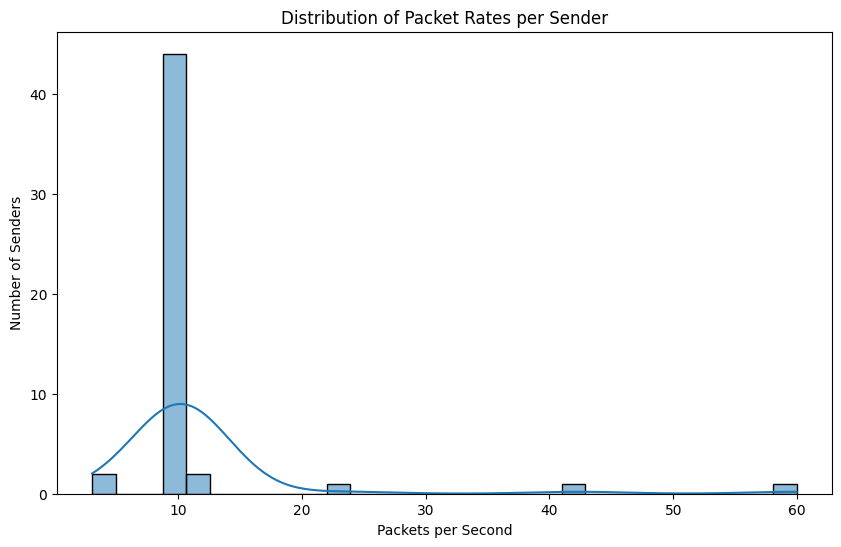

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = 'Dataset_pkt_28.json'

with open(file_path, 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# === Basic Info ===
print("Total packets:", len(df))
print("Unique senders:", df['senderID'].nunique())
print(df.head())

# === Add latency column ===
df['latency'] = df['rcvtime'] - df['sendtime']

# === Sender-level aggregation ===
sender_stats = df.groupby('senderID').agg(
    total_packets=('messageID', 'count'),
    avg_latency=('latency', 'mean'),
    std_latency=('latency', 'std'),
    first_send=('sendtime', 'min'),
    last_send=('sendtime', 'max'),
).reset_index()

# === Calculate rate per sender (pkts/sec) ===
sender_stats['duration'] = sender_stats['last_send'] - sender_stats['first_send']
sender_stats['pkt_rate'] = sender_stats['total_packets'] / sender_stats['duration'].replace(0, 1e-6)

# === Sort by packet rate ===
top_senders = sender_stats.sort_values(by='pkt_rate', ascending=False)

print("\nTop senders by packet rate:")
print(top_senders.head())

# === Plotting ===
plt.figure(figsize=(10, 6))
sns.histplot(sender_stats['pkt_rate'], bins=30, kde=True)
plt.title("Distribution of Packet Rates per Sender")
plt.xlabel("Packets per Second")
plt.ylabel("Number of Senders")
plt.show()


Total packets: 2819
Unique senders: 10
       sendtime       rcvtime  senderID  messageID  \
0  25231.016249  25231.016356       292    2468657   
1  25231.042111  25231.042218       340    2470662   
2  25231.046038  25231.046151       370    2471283   
3  25231.094467  25231.094586        58    2475523   
4  25231.097646  25231.097759       136    2475805   

                                       position  \
0  [5550.3661976747935, 4999.749980784562, 0.0]   
1   [5384.815893869691, 5032.183803689805, 0.0]   
2   [5297.504615570217, 5040.986111033719, 0.0]   
3    [5544.46820819728, 4997.072322123463, 0.0]   
4  [5506.0759778292795, 5005.234313756915, 0.0]   

                                               speed   heading  ddostype  \
0                                  [-0.0, -0.0, 0.0]  0.108223         0   
1      [17.426557048558674, -1.852950369722824, 0.0]  0.108223         0   
2     [14.432374575945879, -1.5864888798463608, 0.0]  0.108223         0   
3                        

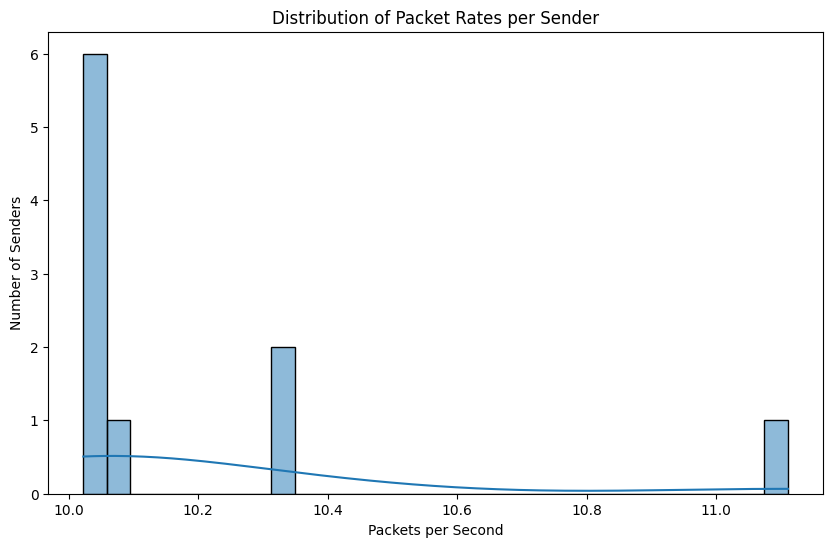

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = 'Dataset_pkt_376.json'

with open(file_path, 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# === Basic Info ===
print("Total packets:", len(df))
print("Unique senders:", df['senderID'].nunique())
print(df.head())

# === Add latency column ===
df['latency'] = df['rcvtime'] - df['sendtime']

# === Sender-level aggregation ===
sender_stats = df.groupby('senderID').agg(
    total_packets=('messageID', 'count'),
    avg_latency=('latency', 'mean'),
    std_latency=('latency', 'std'),
    first_send=('sendtime', 'min'),
    last_send=('sendtime', 'max'),
).reset_index()

# === Calculate rate per sender (pkts/sec) ===
sender_stats['duration'] = sender_stats['last_send'] - sender_stats['first_send']
sender_stats['pkt_rate'] = sender_stats['total_packets'] / sender_stats['duration'].replace(0, 1e-6)

# === Sort by packet rate ===
top_senders = sender_stats.sort_values(by='pkt_rate', ascending=False)

print("\nTop senders by packet rate:")
print(top_senders.head())

# === Plotting ===
plt.figure(figsize=(10, 6))
sns.histplot(sender_stats['pkt_rate'], bins=30, kde=True)
plt.title("Distribution of Packet Rates per Sender")
plt.xlabel("Packets per Second")
plt.ylabel("Number of Senders")
plt.show()


Loaded 622389 total rows from 76 files.
       sendtime       rcvtime  senderID  messageID  \
0  25200.003363  25200.003479       262        860   
1  25200.006415  25200.006520       160        934   
2  25200.009710  25200.009819       130       1356   
3  25200.011873  25200.011986       154       1441   
4  25200.012893  25200.013008        94       1625   

                                       position  \
0    [5732.167012765934, 4891.38384378471, 0.0]   
1   [5817.589821564664, 5087.721446209872, 0.0]   
2   [5745.959105265088, 4893.973772397958, 0.0]   
3   [5904.747163215797, 5219.536367086424, 0.0]   
4  [5735.823659478266, 4912.1616541037265, 0.0]   

                                            speed  heading  ddostype  msgtype  
0                                 [0.0, 0.0, 0.0]   2.0395         0        0  
1   [6.309877460424007, -3.0760420570534235, 0.0]   2.0395         0        0  
2                                [-0.0, 0.0, 0.0]   2.0395         0        0  
3  [-3.3

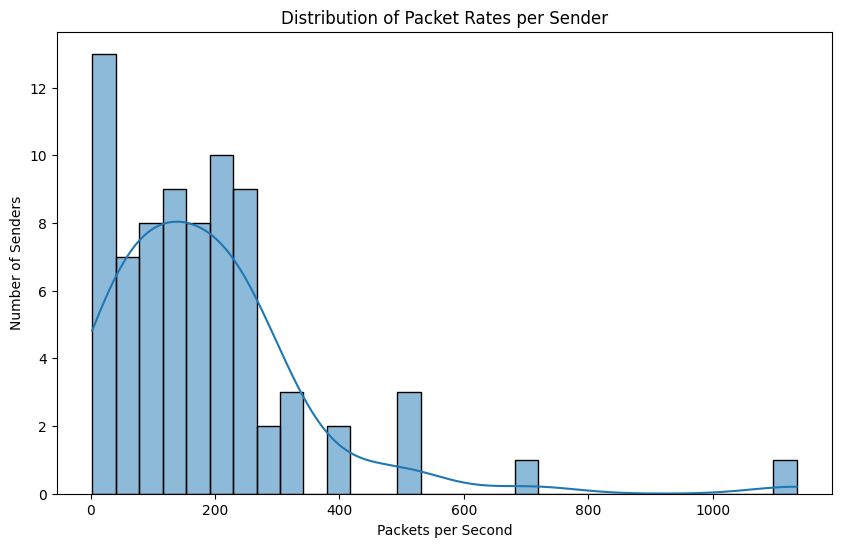

In [4]:


import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob


# file_path = 'Dataset_pkt_28.json'

# with open(file_path, 'r') as f:
#     data = [json.loads(line) for line in f]

# df = pd.DataFrame(data)

file_list = glob.glob("Dataset_pkt_*.json")


# === Step 2: Load and Merge ===
dataframes = []

for file in file_list:
    with open(file, 'r') as f:
        data = [json.loads(line) for line in f]
        df_temp = pd.DataFrame(data)
        dataframes.append(df_temp)

# Concatenate all DataFrames
df = pd.concat(dataframes, ignore_index=True)

print(f"Loaded {len(df)} total rows from {len(file_list)} files.")
print(df.head())


# === Basic Info ===
print("Total packets:", len(df))
print("Unique senders:", df['senderID'].nunique())
print(df.head())

# === Add latency column ===
df['latency'] = df['rcvtime'] - df['sendtime']

# === Sender-level aggregation ===
sender_stats = df.groupby('senderID').agg(
    total_packets=('messageID', 'count'),
    avg_latency=('latency', 'mean'),
    std_latency=('latency', 'std'),
    first_send=('sendtime', 'min'),
    last_send=('sendtime', 'max'),
).reset_index()

# === Calculate rate per sender (pkts/sec) ===
sender_stats['duration'] = sender_stats['last_send'] - sender_stats['first_send']
sender_stats['pkt_rate'] = sender_stats['total_packets'] / sender_stats['duration'].replace(0, 1e-6)

# === Sort by packet rate ===
top_senders = sender_stats.sort_values(by='pkt_rate', ascending=False)

print("\nTop senders by packet rate:")
print(top_senders.head())

# === Plotting ===
plt.figure(figsize=(10, 6))
sns.histplot(sender_stats['pkt_rate'], bins=30, kde=True)
plt.title("Distribution of Packet Rates per Sender")
plt.xlabel("Packets per Second")
plt.ylabel("Number of Senders")
plt.show()



DDoS Type Distribution:
ddostype
0    353676
4    268713
Name: count, dtype: int64


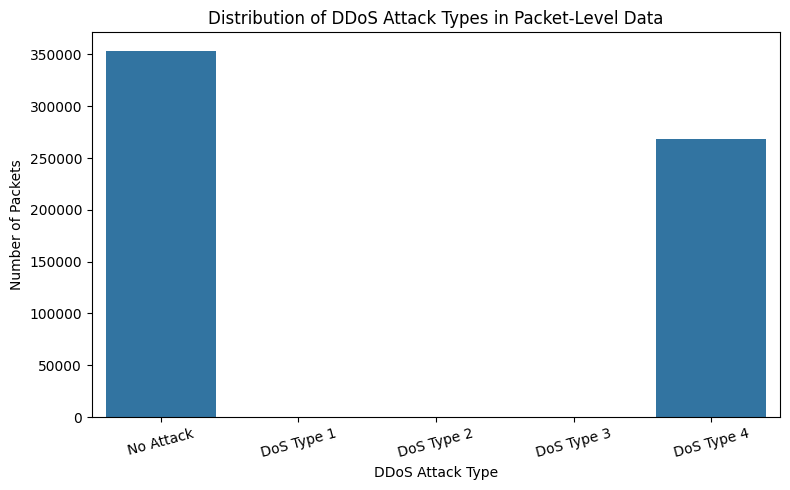

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Show unique ddostype values and their counts
print("\nDDoS Type Distribution:")
print(df['ddostype'].value_counts().sort_index())

# Optional: Add readable labels
ddos_labels = {
    0: 'No Attack',
    1: 'DoS Type 1',
    2: 'DoS Type 2',
    3: 'DoS Type 3',
    4: 'DoS Type 4'
}

df['ddos_label'] = df['ddostype'].map(ddos_labels)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='ddos_label', order=[ddos_labels[i] for i in sorted(ddos_labels.keys())])
plt.title("Distribution of DDoS Attack Types in Packet-Level Data")
plt.ylabel("Number of Packets")
plt.xlabel("DDoS Attack Type")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
